# Black Friday--Cluster

## dataset description

"Dataset of 550 000 observations about the black Friday in a retail store, it contains different kinds of variables either numerical or categorical. It contains missing values."

## raw data


In [102]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [5]:
df_allData=pd.read_csv('BlackFriday.csv')
print(df_allData.sample(n=5))

        User_ID Product_ID Gender    Age  Occupation City_Category  \
324155  1001891  P00345742      M  46-50           1             C   
384692  1005193  P00084842      M  36-45          12             B   
34262   1005282  P00183642      F  18-25           4             B   
328396  1002590  P00128342      M  18-25           4             A   
270293  1005650  P00367042      F  36-45          12             B   

       Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
324155                          3               1                   1   
384692                          2               1                   8   
34262                           1               1                   4   
328396                          0               0                   5   
270293                          2               1                   8   

        Product_Category_2  Product_Category_3  Purchase  
324155                 2.0                15.0     11700  
384692                

raw data has 12 columns and there are a lot of missing values in "Product_Category_2" and "Product_Category_3". Which means some of the product whould just have one category.

## data pre-processing


In our opinion, we think our model would do cluster on different people, so our key is people.

But the dataset includes different records of one-single people. So at the beginning we use gruopby to get each people's whole records. 

Then we try to get the mode of each one's "Product_Category_1" to represent the main product category and get the mean of one people's whole "Purchase" as a feature of "average purchase". (We are not sure weather this is a good way buy we have to do this because we cannot keep all the data to train)

What's more, we change the "Gender" attribute to 0-1 attribute.

In [13]:
groupByUserData=df_allData.groupby(['User_ID'])

times=df_allData['User_ID'].value_counts()
times=times.sort_index()

#get the mean
meanData=groupByUserData.mean()

#get the mode
modeData=groupByUserData.agg(lambda x: stats.mode(x)[0][0])

mean_mode_data={'Gender':modeData['Gender'],'Occupation':modeData['Occupation'],'Age':modeData['Age'],'City_Category':modeData['City_Category'],'Marital_Status':modeData['Marital_Status'],'Product_CateGory_1':modeData['Product_Category_1'],'Stay_In_Current_City_Years':modeData['Stay_In_Current_City_Years']}
mean_mode_data=pd.DataFrame(mean_mode_data)
mean_mode_data['times']=times
mean_mode_data['Gender_M']=pd.get_dummies(mean_mode_data['Gender'])['M']
mean_mode_data=mean_mode_data.drop(['Gender'],axis=1)
mean_mode_data['Purchase']=meanData['Purchase']

print (mean_mode_data.sample(5))

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


         Occupation    Age City_Category  Marital_Status  Product_CateGory_1  \
User_ID                                                                        
1004956          15  36-45             B               1                   8   
1000839           0  26-35             A               0                   8   
1003510           4  18-25             B               1                   5   
1003016          12  18-25             A               0                   1   
1005555          10   0-17             B               0                   1   

        Stay_In_Current_City_Years  times  Gender_M      Purchase  
User_ID                                                            
1004956                          1    120         1   9324.600000  
1000839                          2    435         1  10761.390805  
1003510                          1     32         0   9913.406250  
1003016                          1     18         1  11067.111111  
1005555                        

## feature extraction

This is the hardest part of our cluster project.

There are two key problems we have to face:

##### 1. **how to handle the discrete attributes?**
    
    There are a lot of disordered discrete attributes in our data, likes "Marital_Status", "Gender" and "Product_Category_1", we cannot just simplely calculate their euclidean distance. We try to take them as continuous variables and apply several cluster algorithms on them but we just get a bad output which looks no special meanning.

##### 2. **how to evaluate our feature extraction performance?**

    Since we have so many choices of extracting the features and we do not know how to assign the weights on these feautres and this is a cluster problem, we had not a clearly mind of have to evaluate our work when we doing the feature extraction. And it is unrealistic to try all the choices and train them then evaluate the final models. The best solution is that we can find some explainable output of our feature extraction.
    
#### deal with discrete attributes

To solve the key problems 1, we came up with ideas.

1. do one-hot encoding on the discrete attributes

1. use k-modes or k-prototype model

1. drop those discrete attributes

But their would raise some new problems if we use these solutions:

    one-hot encoding would make the features very sparse.
    
    It is not easy to combine the VDM distance and Minkowski distance together.
    
    Some discrete features may be very important like occupation but it would have a lot of possible value.
    
#### deal with evaluation

We do not find a good way to solve this problem, we just living with it, but we still did some tries. Likes using the average purchase to evaluate the cluster output. And we use Calinski-Harabasz score and Value Difference Metrix to evalue our final clusters.

## data pre-processing before training

Since we have features of different units, we must do the data standardization and assign different weights to different features.

We choose min-max standardization and assign the weights by feeling.

## specific approach 1 by Chaoji: k-modes

I try to use the k-modes only on the categorical values to train a model, then use one-hot encoidng data to calculate the jaccard distance and euclidean distance inside each cluster.

In [15]:
from kmodes.kmodes import KModes

In [168]:
X=pd.DataFrame({'Gender':modeData['Gender'],'Occupation':modeData['Occupation'],'Age':modeData['Age'],'City_Category':modeData['City_Category'],'Marital_Status':modeData['Marital_Status'],'Product_CateGory_1':modeData['Product_Category_1'],"Stay_In_Current_City_Years":modeData["Stay_In_Current_City_Years"]})

one_hot_city=pd.get_dummies(mean_mode_data['City_Category'])
one_hot_age=pd.get_dummies(mean_mode_data['Age'])
one_hot_occupation=pd.get_dummies(mean_mode_data['Occupation'])
one_hot_years=pd.get_dummies(mean_mode_data['Stay_In_Current_City_Years'])
one_hot_product=pd.get_dummies(mean_mode_data['Product_CateGory_1'])
XX=pd.concat([one_hot_age,one_hot_city,one_hot_occupation,one_hot_years,one_hot_product],axis=1)
XX['Gender_M']=mean_mode_data['Gender_M']
XX['Marital_Status']=mean_mode_data['Marital_Status']

print ("categorical data:")
print(X.sample(2))
print("one-hot encoding data:")
print(XX.sample(2))


categorical data:
        Gender  Occupation    Age City_Category  Marital_Status  \
User_ID                                                           
1004322      F           6  51-55             B               0   
1004518      M           0  26-35             C               0   

         Product_CateGory_1 Stay_In_Current_City_Years  
User_ID                                                 
1004322                   8                          1  
1004518                   3                         4+  
one-hot encoding data:
         0-17  18-25  26-35  36-45  46-50  51-55  55+  A  B  C  \
User_ID                                                          
1002359     0      0      0      0      0      0    1  0  0  1   
1005850     0      0      1      0      0      0    0  0  0  1   

              ...        8  10  11  12  13  15  16  18  Gender_M  \
User_ID       ...                                                  
1002359       ...        0   0   0   0   0   0   0   0       

At first, I think the key is finding the best clusters number n, but I don't have ideas about how to evalue the output. I just thought maybe different cluster's average price can reflect some difference.

I try to use jaccard distance and eulicdean distance, but the jaccard distance inside a cluster would alway decrease when n increase.

In [253]:
from sklearn.metrics import jaccard_similarity_score
ecArr=[]
jcArr=[]
jcXArr=[]
for i in range(2,10):
    km=KModes(n_clusters=i)
    y=km.fit_predict(X)
    tempArrjc=[]
    tempArrec=[]
    tempArrjcX=[]
    for j in range(i):
        #print(sum(y==j))
        #print(XX[y==j].mode())
        jcscore=[]
        ecscore=[]
        jcXscore=[]
        for k in XX[y==j].T:
            try:
                #jcscore.append(jaccard_similarity_score(XX.loc[k],XX[y==j].mode().T[0]))
                
                ecscore.append(np.linalg.norm(np.array(XX.loc[k])-np.array(XX[y==j].mode().T[0])))
                
                jcXscore.append(jaccard_similarity_score(list(X.loc[k]),list(X[y==j].mode().T[0])))

            except:
                #print(XX.loc[k].T)
                #print(XX[y==j].mode())
                print(k)
                break;
        #print(np.mean(jcscore))
        #tempArrjc.append(np.mean(jcscore))
        #tempArrec.append(np.mean(ecscore))
        tempArrjcX.append(np.mean(jcXscore))

    print("n_cluster =",i,":",np.mean(tempArrjcX))
    #jcArr.append(np.mean(tempArrjc))
    #ecArr.append(np.mean(tempArrec))
    jcXArr.append(np.mean(tempArrjcX))

n_cluster = 2 : 0.5000269875392017
n_cluster = 3 : 0.5294875041896924
n_cluster = 4 : 0.5534965418820955
n_cluster = 5 : 0.5645384012323531
n_cluster = 6 : 0.5720855312627525
n_cluster = 7 : 0.5890558734522645
n_cluster = 8 : 0.6010495871774273
n_cluster = 9 : 0.6128901655705694


Lack of the ways to evaluate better n, I decide to focus on features more rather than n.

Then I camp up with an idea that I can calculate the eulidean distance between a cluster's mode point and the other point's mode point.

So I do some tries.

In [256]:
XXXX=X.drop(['Marital_Status','Product_CateGory_1','Stay_In_Current_City_Years','Age'],axis=1)
print(XXXX.sample(2))

        Gender  Occupation City_Category
User_ID                                 
1005314      F           0             A
1002289      F           1             C


In [274]:
from sklearn.metrics import jaccard_similarity_score
ecArr=[]
jcArr=[]
jcXArr=[]
for i in range(10,11):
    km=KModes(n_clusters=i)
    y=km.fit_predict(XXXX)
   

In [278]:
dis_jc=[]
dis_ec=[]
for i in range(10):
    dis_jc.append(jaccard_similarity_score(list(XXXX[y==i].mode().T[0]),list(XXXX[y!=i].mode().T[0])))
    
print("average jc distance in selected features:",np.mean(dis_jc))
    
for i in range(10):
    dis_ec.append(np.linalg.norm((np.array(XX[y==i].mode().T[0])-np.array(XX[y!=i].mode().T[0]))))
    
print("average ec distance in all one-hot features:",np.mean(dis_ec))

average jc distance in selected features: 0.5
average ec distance in all one-hot features: 1.3071067811865476


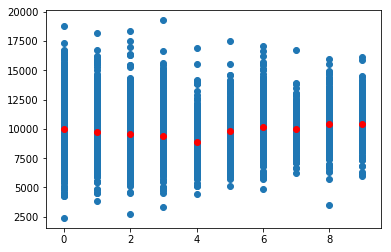

In [276]:
purchase_y=pd.DataFrame({"y":y,"Purchase":mean_mode_data["Purchase"]})
plt.scatter(purchase_y['y'],purchase_y['Purchase'])
for i in range(10):
    plt.scatter(i,purchase_y[purchase_y['y']==i].Purchase.mean(),c='r')

In [287]:
XXXXX=X.drop(['Stay_In_Current_City_Years'],axis=1)
print(XXXXX.sample(2))

        Gender  Occupation    Age City_Category  Marital_Status  \
User_ID                                                           
1004639      M          11  36-45             B               0   
1004422      M           5  26-35             A               1   

         Product_CateGory_1  
User_ID                      
1004639                   5  
1004422                   5  


In [288]:
ecArr=[]
jcArr=[]
jcXArr=[]
for i in range(10,11):
    km=KModes(n_clusters=i)
    y=km.fit_predict(XXXXX)

dis_jc=[]
dis_ec=[]
for i in range(10):
    dis_jc.append(jaccard_similarity_score(list(XXXXX[y==i].mode().T[0]),list(XXXXX[y!=i].mode().T[0])))
    
for i in range(10):
    dis_ec.append(np.linalg.norm((np.array(XX[y==i].mode().T[0])-np.array(XX[y!=i].mode().T[0]))))
    
print("average jc distance in selected features:",np.mean(dis_jc))
print("average ec distance in all one-hot features:",np.mean(dis_ec))

average jc distance in selected features: 0.35
average ec distance in all one-hot features: 1.8432220400206423


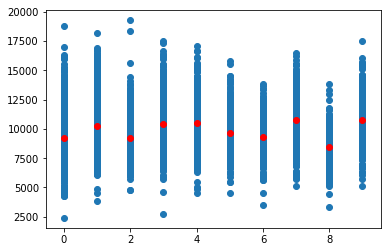

In [284]:
purchase_y=pd.DataFrame({"y":y,"Purchase":mean_mode_data["Purchase"]})
plt.scatter(purchase_y['y'],purchase_y['Purchase'])
for i in range(10):
    plt.scatter(i,purchase_y[purchase_y['y']==i].Purchase.mean(),c='r')

### conclusion

Thought the process is hard, I think I get something surpringly at the end.

I paid too much attentation on the cluster number n and the distance between a cluster but I haven't had a great evaluation way.

But when I campared different features as input to k-modes with the same n, I got some pretty things.

The change in average euclidean distance showed the feature 'Marital_Status' , 'Product_CateGory_1', 'Age' do influence on the whole cluster performance.

What't more, the 'Purchase' would really reflect the performance of cluster in some way.

With this conclusion, it means we can do further work about how different categorial features influence the cluster. The best feature may have the biggest influence on average euclidean distance.

## specific approach 2:

In [ ]:
def recenter_regularize(X):
    #X_mean = np.mean(X, axis = 1)[np.newaxis]
    X_mean = np.mean(X)
    X_centered = X - X_mean
    #X_norm = np.linalg.norm(X_centered)[np.newaxis]
    X_norm = np.linalg.norm(X_centered)
    X_normalized = X_centered/X_norm
    return X_normalized

numGroup = 10

print(mean_mode_data['times'])
print(mean_mode_data['Purchase'])
print(np.array(mean_mode_data.times))
times_arr = np.array(mean_mode_data.times)
times_regularized = recenter_regularize(times_arr)
purchases_regularized = recenter_regularize(np.array(mean_mode_data['Purchase']))

ini_index = np.random.choice(a=range(len(times_arr)), size=len(times_arr), replace=False)

X_2d = np.asarray([times_regularized, purchases_regularized]).T
X_2d_group = []
icr = int(np.floor(len(ini_index)/numGroup))
for i in range(numGroup):
    X_2d_group.append(X_2d[i*icr:(i+1)*icr])

isFinished = False
counter = 0
while((not isFinished) and counter <= 200):
    isFinished = True
    numDiff=0
    X_mean_group = [np.mean(X, axis = 0) for X in X_2d_group]
    X_2d_group_new = [[] for h in range(numGroup)]
    for i in range(numGroup):
        
        X_2d_this = X_2d_group[i]
        for j in range(len(X_2d_this)):
            
            sample = X_2d_this[j]
            dist_group = [[] for h in range(numGroup)]
            for k in range(numGroup):
                dist_group[k] = np.linalg.norm(sample - X_mean_group[k])
            
            group = np.argmin(dist_group)
            if(i != group):
                isFinished = False
                numDiff += 1
            X_2d_group_new[group].append(sample)
    X_2d_group = X_2d_group_new
    counter+=1

    

In [61]:
def recenter_regularize(X):
    #X_mean = np.mean(X, axis = 1)[np.newaxis]
    X_mean = np.mean(X)
    X_centered = X - X_mean
    #X_norm = np.linalg.norm(X_centered)[np.newaxis]
    X_norm = np.linalg.norm(X_centered)
    X_normalized = X_centered/X_norm
    return X_normalized

numGroup = 10

print(mean_mode_data['times'])
print(mean_mode_data['Purchase'])
print(np.array(mean_mode_data.times))
times_arr = np.array(mean_mode_data.times)
times_regularized = recenter_regularize(times_arr)
purchases_regularized = recenter_regularize(np.array(mean_mode_data['Purchase']))

ini_index = np.random.choice(a=range(len(times_arr)), size=len(times_arr), replace=False)

X_2d = np.vstack((np.asarray([times_regularized, purchases_regularized]), list(range(len(times_regularized))))).T
X_2d_group = []
icr = int(np.floor(len(ini_index)/numGroup))
for i in range(numGroup):
    X_2d_group.append(X_2d[i*icr:(i+1)*icr])

isFinished = False
counter = 0
while((not isFinished) and counter <= 200):
    print("progressing: ")
    isFinished = True
    numDiff=0
    X_mean_group = [np.mean(X, axis = 0) for X in X_2d_group]
    X_2d_group_new = []
    for i in range(numGroup):
        
        X_2d_this = X_2d_group[i]
        X_2d_group_new =[[] for h in range(numGroup)]
        for j in range(len(X_2d_this)):
           
            sample = X_2d_this[j]
            dist_group = [[] for h in range(numGroup)]
            for k in range(numGroup):
                #print(len(sample))
                #print(X_mean_group[k].shape)
                dist_group[k] = np.linalg.norm(sample[:2] - X_mean_group[k][:2])
            
            group = np.argmin(dist_group)
            #print(group)
            if(i != group):
                isFinished = False
                numDiff += 1
                X_2d_group_new[group].append(sample)
            else:
                X_2d_group_new[group].append(sample)
        #if(len(X_2d_this_new)>0):
        #for k in range(numGroup):
        #    X_2d_group_new[k] = np.vstack(X_2d_group_new[k])
        #else:
        #    X_2d_group_new.append(np.asarray([]))
    print(numDiff)
    X_2d_group = X_2d_group_new
    print(len(X_2d_group))
    counter+=1

    

User_ID
1000001     34
1000002     76
1000003     29
1000004     13
1000005    106
1000006     46
1000007     16
1000008     76
1000009     57
1000010    222
1000011     69
1000012     11
1000013     60
1000014     13
1000015    116
1000016     21
1000017    114
1000018    179
1000019    144
1000020     12
1000021     13
1000022    155
1000023    171
1000024     76
1000025     43
1000026    226
1000027     41
1000028     57
1000029     52
1000030     30
          ... 
1006011     99
1006012     15
1006013     72
1006014     54
1006015     32
1006016    469
1006017     15
1006018     76
1006019     44
1006020     23
1006021     64
1006022     24
1006023     77
1006024     55
1006025    142
1006026     42
1006027     22
1006028     26
1006029     14
1006030     53
1006031     30
1006032     51
1006033     35
1006034     11
1006035    143
1006036    476
1006037    116
1006038     10
1006039     67
1006040    169
Name: times, Length: 5891, dtype: int64
User_ID
1000001     9808.264706
10000

AttributeError: 'list' object has no attribute 'shape'

In [60]:
print(type(X_2d_group_new[0]))
#print(np.asarray(X_2d_group))

<class 'numpy.ndarray'>


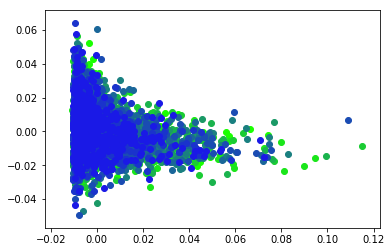

In [34]:
X_2d_group_arr = np.asarray(X_2d_group)
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(numGroup):
    for j in range(len(X_2d_group_arr[i])):
        ax.scatter(X_2d_group_arr[i][j][0], X_2d_group_arr[i][j][1], color = [0.1, 1-0.1*i, 0.1*i])
   
        
plt.show()

In [50]:
pd.DataFrame(X_2d_group_arr[0])

0         1    2
0   -0.009626  0.041012  1.0
1   -0.009257  0.032983  1.0
2   -0.009749  0.038548  1.0
3   -0.004828  0.024484  1.0
4   -0.009380  0.029024  1.0
5   -0.003106  0.025356  1.0
6   -0.003229  0.052222  1.0
7   -0.003229  0.039654  1.0
8   -0.006305  0.041396  1.0
9   -0.007658  0.030272  1.0
10  -0.006182  0.030639  1.0
11  -0.006797  0.028716  1.0
12  -0.000892  0.034812  1.0
13  -0.001507  0.042949  1.0
14  -0.006797  0.045234  1.0
15  -0.009380  0.028116  1.0
16  -0.009380  0.029951  1.0
17  -0.004459  0.027730  1.0
18  -0.007412  0.028873  1.0
19  -0.004213  0.038651  1.0
20  -0.009257  0.034480  1.0
21  -0.009134  0.027686  1.0
22  -0.004459  0.039634  1.0
23  -0.009134  0.031171  1.0
24  -0.009626  0.028905  1.0
25  -0.009872  0.035725  1.0
26  -0.006428  0.030280  1.0
27  -0.009995  0.026939  1.0
28  -0.001507  0.024637  1.0
29  -0.007904  0.034889  1.0
..        ...       ...  ...
267 -0.007289  0.031328  1.0
268 -0.009134  0.038820  1.0
269 -0.010487  0.024437  1.0
270 -0.007904  0.037075  1.0
271  0.000092  0.033422  1.0
272 -0.009134  0.038904  1.0
273 -0.007781  0.025864  1.0
274 -0.005566  0.028973  1.0
275 -0.009011  0.030092  1.0
276 -0.009872  0.024608  1.0
277 -0.000523  0.026592  1.0
278 -0.006797  0.036736  1.0
279 -0.009011  0.035379  1.0
280 -0.009503  0.029438  1.0
281 -0.009134  0.038548  1.0
282 -0.009011  0.029470  1.0
283 -0.003844  0.026295  1.0
284 -0.009380  0.027197  1.0
285 -0.006551  0.046745  1.0
286 -0.008396  0.030599  1.0
287 -0.009011  0.057836  1.0
288 -0.008888  0.026361  1.0
289 -0.008396  0.043948  1.0
290 -0.001753  0.029898  1.0
291 -0.004459  0.026078  1.0
292 -0.006920  0.030804  1.0
293 -0.009872  0.048824  1.0
294  0.007718  0.026134  1.0
295  0.008579  0.025899  1.0
296 -0.008150  0.023515  1.0

[297 rows x 3 columns]

## specific model 3:

## Specific Model 3: ROCK Clustering by Changlin Jiang
- After searching relavant paper dealing with discrete features clustering,we decide to implement a algorithm termed ROCK.  
- The main idea is:  
    - Compute the Jaccard score between 2 data points.Input a threshold theta such that if the Jaccard score is larger than the threshold,say these 2 points are neighbors (i.e. they have a Neighbor label which is originally 0 and can be set to 1 if their Jaccard score is larger than the threshold theta.)  
    - Compute the Neighbor label of every 2 data,put them in a Neighbors Matrix A,A[i,j]=1 if point i and j are neighbors,A[i,j]=0 if not.
    - Initialization:If note the number of data points with n,initialize the clusters with n clusters,each cluster includes only one data point.
    - Gooodness:The goodness of 2 clusters $C_i$ and $C_j$ can be determined by: $$goodness=\frac{link(C_i,C_j)}{(n1+n2)^{1+2f(\theta)}-n1^{1+2f(\theta)}-n2^{1+2f(\theta)}}$$In this formula,link(Ci,Cj) is the total number of neighbors of the two clusters $C_i$ and $C_j$,$$f(\theta)=\frac{1-\theta}{1+\theta}$$is the penalty if the size of the cluster has got too many members.
    - Compute goodness of every 2 different clusters,find the pair of clusters with the largest goodness.
    - Process:Merge the two clusters into one clusters and loop the whole process untill converge or number of clusters is smaller than a wanted number.

In [7]:
X=np.array(X)
X0=list(X[:,0])
X2=list(X[:,2])
X3=list(X[:,3])
X6=list(X[:,6])

X0=[0 if x=='M' else 1 for x in X0]

X2=[0 if x=='0-17' else x for x in X2]
X2=[1 if x=='18-25' else x for x in X2]
X2=[2 if x=='26-35' else x for x in X2]
X2=[3 if x=='36-45' else x for x in X2]
X2=[4 if x=='46-50' else x for x in X2]
X2=[5 if x=='51-55' else x for x in X2]
X2=[6 if x=='55+' else x for x in X2]

X3=[0 if x=='A' else x for x in X3]
X3=[1 if x=='B' else x for x in X3]
X3=[2 if x=='C' else x for x in X3]

X6=[0 if x=='0' else x for x in X6]
X6=[1 if x=='1' else x for x in X6]
X6=[2 if x=='2' else x for x in X6]
X6=[3 if x=='3' else x for x in X6]
X6=[4 if x=='4+' else x for x in X6]

X[:,0]=np.array(X0).T
X[:,2]=np.array(X2).T
X[:,3]=np.array(X3).T
X[:,6]=np.array(X6).T

X1=X[:300,:]
print(X1)

[[1 10 0 ... 0 3 2]
 [0 16 6 ... 0 1 4]
 [0 15 2 ... 0 1 3]
 ...
 [0 7 2 ... 1 5 1]
 [0 0 2 ... 0 10 1]
 [1 0 1 ... 1 11 3]]


### Derive neighbors matrix A:

In [8]:
def neighbors_matrix(data,theta):
    m,n=np.shape(data)
    A=np.zeros((m,m))
    for i in range(m):
        for j in range(m):
            if jaccard_similarity_score(np.reshape(list(data[i,:]),-1),np.reshape(list(data[j,:]),-1))>=theta:
                A[i,j]=1
    return A.astype(int)

A=neighbors_matrix(X1,0.5)
print(A)

[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


### Compute the $link(C_i,C_j)$ of $C_i$ and $C_j$

In [30]:
def link(A,c1,c2):
    m,n=np.shape(A)
    sum_=0
    if isinstance(c1,int)==True:
        n1=1
    else:
        n1=len(c1)
    if isinstance(c2,int)==True:
        n2=1
    else:
        n2=len(c2)
    for i in range(n1):
        for j in range(n2):
            if isinstance(c1,int)==True:
                k1=c1
            else:
                k1=c1[i]
            if isinstance(c2,int)==True:
                k2=c2
            else:
                k2=c2[j]
            sum_+=A[k1,k2]
    return sum_

### Compute goodness of $C_i$ and $C_j$

In [10]:
def goodness(A,c1,c2,theta):
    if isinstance(c1,int)==True:
        n1=1
    else:
        n1=len(c1)
    if isinstance(c2,int)==True:
        n2=1
    else:
        n2=len(c2)
    ftheta=(1-theta)/(1+theta)
    if c1==c2:
        gm=0
    else:
        gm=link(A,c1,c2)/((n1+n2)**(1+2*ftheta)-n1**(1+2*ftheta)-n2**(1+2*ftheta))
    return gm

### Find the best pair

In [21]:
def find_best_pair(A,clusters,theta):
    maximum_goodness = 0.0;
    cluster_indexes = [-1, -1];
        
    for i in range(0, len(clusters)):
        for j in range(i + 1, len(clusters)):
            gm = goodness(A,clusters[i], clusters[j],theta);
            if (gm > maximum_goodness):
                maximum_goodness = gm;
                cluster_indexes = [i, j]
        
    return cluster_indexes;

In [24]:
def merge(clusters,cluster_indexes):
    if isinstance(clusters[cluster_indexes[0]],int)==True:
        clusters[cluster_indexes[0]]=[clusters[cluster_indexes[0]]]
    if isinstance(clusters[cluster_indexes[1]],int)==True:
        clusters[cluster_indexes[1]]=[clusters[cluster_indexes[1]]]
    clusters[cluster_indexes[0]].extend(clusters[cluster_indexes[1]])
    clusters.pop(cluster_indexes[1])
    
    return clusters

### Process and clustering result

In [29]:
clusters=list([i for i in range(300)])
for i in range(len(clusters)-10):
    new_clusters=merge(clusters,find_best_pair(A,clusters,0.5))
    if len(new_clusters)<=10:
        print("Number of clusters<=10")
        print(clusters)
        break;
    else:
        clusters=new_clusters

Number of clusters<=10
[[0, 18, 83, 190, 206, 48, 72, 96, 115, 149, 196, 5, 10, 36, 66, 197, 215, 103, 163, 192, 244, 272, 111, 135], [1, 13, 16, 24, 28, 49, 58, 63, 81, 82, 84, 97, 110, 114, 116, 117, 125, 139, 170, 177, 181, 184, 202, 221, 247, 251, 255, 274, 289, 175, 238, 278, 283, 91, 128, 140, 14, 218, 226, 257, 258, 80, 166, 223, 161, 267, 19, 252, 256, 159, 213, 70, 122, 185, 188, 195, 107, 2, 231, 55, 143, 118, 209, 266, 60, 210, 224, 74, 178, 38, 158, 89, 98, 127, 141, 241, 54, 8, 245, 240, 131, 187, 172, 263, 225, 295, 296, 37, 67, 65, 148, 198, 186, 234, 269, 292, 11, 237, 30, 87, 108, 271, 182, 168, 298, 20, 35, 132, 222, 230, 165, 205, 212, 219, 254, 40, 105, 208, 216, 138, 21, 33, 59, 153, 201, 193, 220, 43, 44, 104, 176, 273, 157, 293, 249, 53, 99, 156, 229, 261, 285], [3, 6, 12, 22, 41, 45, 100, 121, 126, 144, 145, 173, 279, 73, 90, 200, 243, 259, 265, 268, 294, 79, 112, 113, 130, 62, 207, 204, 277, 77, 102, 211, 253, 291, 57, 106, 286, 236, 250, 39, 92, 46, 235, 61, 1